                      Price
date                       
2024-10-29 22:00:00  103.09
2024-10-29 21:00:00  118.08
2024-10-29 20:00:00  124.05
2024-10-29 19:00:00  140.60
2024-10-29 18:00:00  203.82
...                     ...
2018-10-01 02:00:00   47.59
2018-10-01 01:00:00   47.38
2018-10-01 00:00:00   51.41
2018-09-30 23:00:00   56.10
2018-09-30 22:00:00   59.53

[83881 rows x 1 columns]
2024-05-01 00:00:00
2024-10-29 00:00:00
RMSE: 11.650884509041578


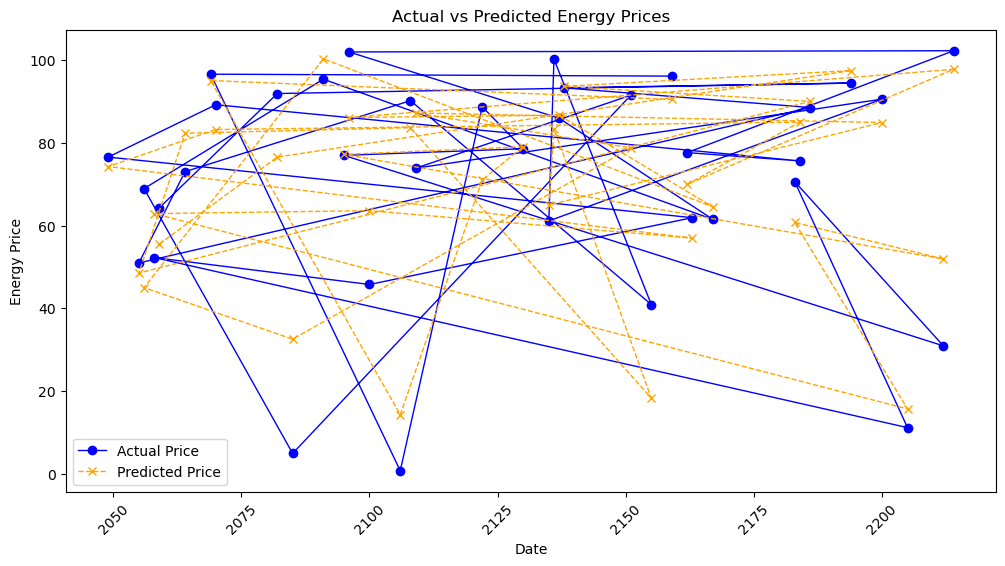

Feature Importances:
                         Feature  Importance
1   Fossil brown coal / lignite    0.594000
4              Fossil hard coal    0.124446
3                    Fossil gas    0.088875
12          Waste non-renewable    0.040953
15                 Wind onshore    0.028610
13              Waste renewable    0.028128
7            Hydro Run-of-River    0.026966
14                Wind offshore    0.018757
11                        Solar    0.015097
10                       Others    0.014602
5                    Fossil oil    0.008327
8         Hydro water reservoir    0.005188
0                       Biomass    0.003136
6                    Geothermal    0.002914
2       Fossil coal-derived gas    0.000000
9                       Nuclear    0.000000


<Figure size 1000x600 with 0 Axes>

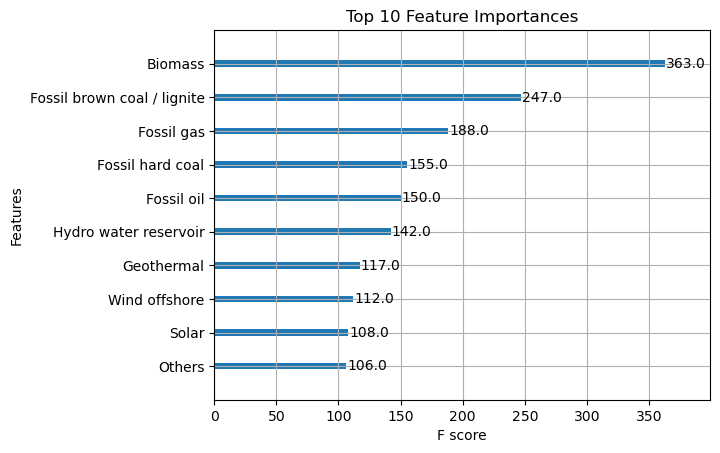

In [36]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
from datetime import datetime

# データの読み込み
prices_df = pd.read_csv('day_ahead_energy_prices.csv', parse_dates=[0], index_col=0)
mix_df = pd.read_csv('daily_market_mix.csv', header=None, names=['Date', 'Energy Source', 'Share'])

# 'Date'列をdatetime形式に変換
mix_df['Date'] = pd.to_datetime(mix_df['Date'], format='%Y_%m_%d')

# データのピボット操作：'Energy Source'を列名としてシェア値を変換
mix_df = mix_df.pivot(index='Date', columns='Energy Source', values='Share').reset_index()
#print(mix_df)

# 'Price' 列名に変換
mix_df['Date'] = pd.to_datetime(mix_df['Date'], format='%Y_%m_%d')
prices_df.rename(columns={'hourly day-ahead energy price': 'Price'}, inplace=True)
prices_df.index = prices_df.index.tz_localize(None)
print(prices_df)

# 日次で平均価格を計算しデータを結合
prices_df = prices_df.resample('D').mean()
start_date = datetime(2024,5,1)
end_date = datetime(2024,10,29)
print(start_date)
print(end_date)
filtered_prices_df = prices_df[(prices_df.index >= start_date) & (prices_df.index <= end_date)]
filtered_mix_df = mix_df[(mix_df['Date'] >= start_date) & (mix_df['Date'] <= end_date)]

# データの結合
data = pd.merge(filtered_prices_df, filtered_mix_df, left_index=True, right_on='Date').drop(columns=['Date'])

# 特徴量とラベルの分離
X = data.drop(columns=['Price'])
y = data['Price']


# 学習と検証用データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoostモデルの学習
model = XGBRegressor()
model.fit(X_train, y_train)

# 予測と評価
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

# 予測と実際の価格の可視化
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue', marker='o', linestyle='-', linewidth=1)
plt.plot(y_test.index, y_pred, label='Predicted Price', color='orange', marker='x', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Energy Price')
plt.title('Actual vs Predicted Energy Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

from xgboost import plot_importance

# 特徴量の重要度を取得
feature_importances = model.feature_importances_

# 特徴量名とその重要度をデータフレームにまとめて、重要度の降順でソート
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 特徴量の重要度を表示
print("Feature Importances:\n", feature_importance_df)

# 特徴量の重要度の可視化
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10)  # 上位10の特徴量を表示
plt.title('Top 10 Feature Importances')
plt.show()


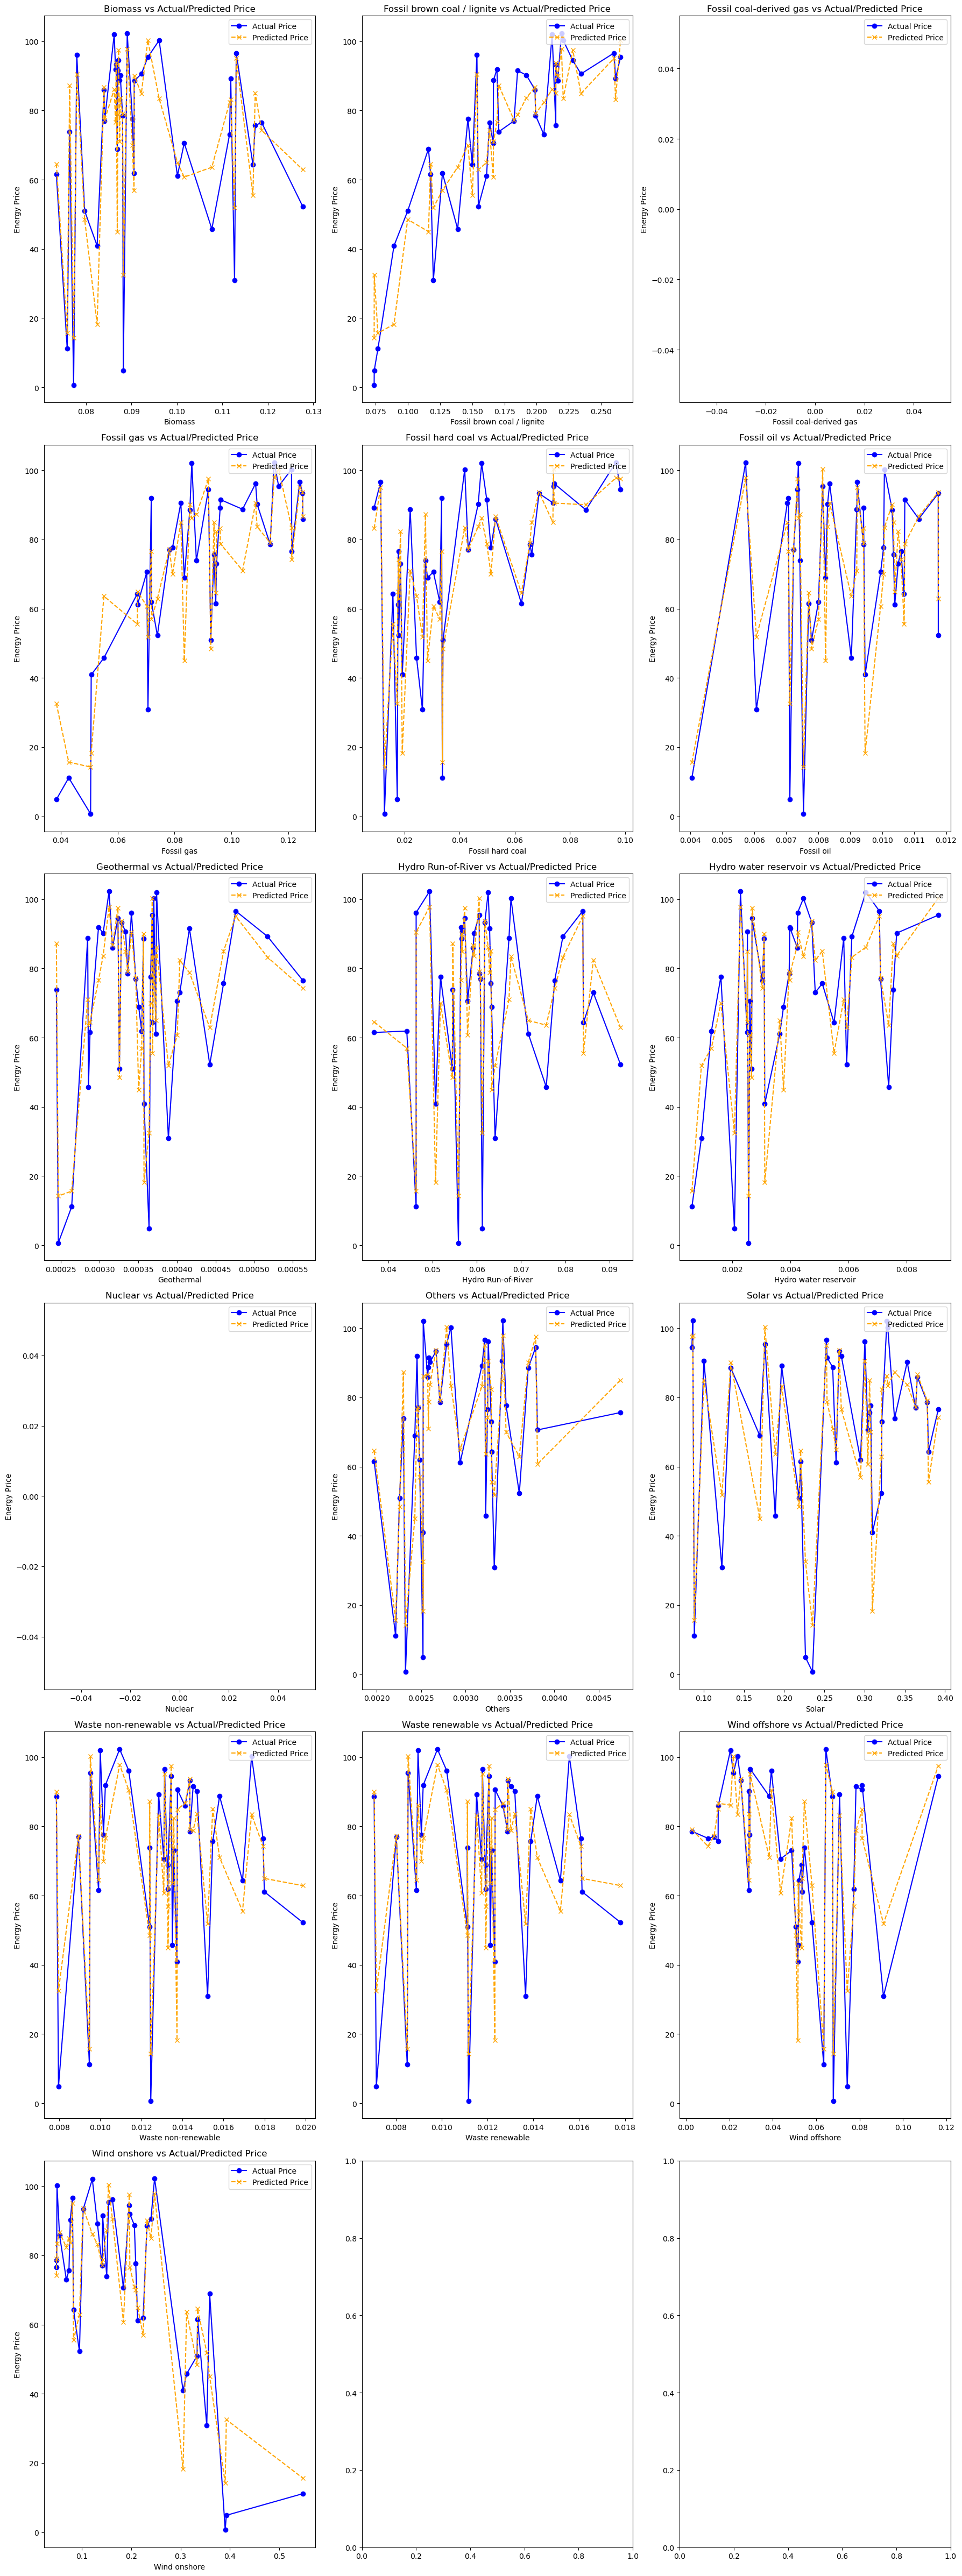

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

# Notebookのセル全体の表示幅を100%に設定
display(HTML("<style>.container { width:100% !important; }</style>"))



# 可視化の設定
num_features = len(X.columns)
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(18, num_features * 3))

# 各特徴量ごとにプロット
for i, feature in enumerate(X.columns):
    # 現在の特徴量のデータを取得
    X_test_feature = X_test[feature].sort_values()  # データをソートして線が滑らかになるように調整
    y_test_sorted = y_test.loc[X_test_feature.index]
    y_pred_sorted = pd.Series(y_pred, index=y_test.index).loc[X_test_feature.index]

    # 実際の価格のプロット（青の実線）
    axes[i // 3, i % 3].plot(X_test_feature, y_test_sorted, color='blue', marker='o', linestyle='-', label='Actual Price')
    
    # 予測した価格のプロット（オレンジの破線）
    axes[i // 3, i % 3].plot(X_test_feature, y_pred_sorted, color='orange', marker='x', linestyle='--', label='Predicted Price')

    # 軸のラベルとタイトルを設定
    axes[i // 3, i % 3].set_title(f'{feature} vs Actual/Predicted Price')
    axes[i // 3, i % 3].set_xlabel(feature)
    axes[i // 3, i % 3].set_ylabel('Energy Price')
    
    # 凡例を各プロットに追加
    axes[i // 3, i % 3].legend(loc='upper right')

# プロットを調整
plt.tight_layout()
plt.show()

